In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [2]:
TRAINING_SAMPLES = 15000
VALIDATION_SAMPLES = 6000
MAX_WORDS = 10000
MAX_FEATURE_LEN = 1000

In [3]:
train_data = pd.read_csv('../Data/train.csv')

nan_idx = train_data.text[pd.isnull(train_data.text)].index.tolist()
train_data.loc[nan_idx, 'text'] = ' '

In [4]:

tokenizer = Tokenizer(num_words=MAX_WORDS)

tokenizer.fit_on_texts(train_data.text)
sequences = tokenizer.texts_to_sequences(train_data.text)

print(f'Znaleziono {len(tokenizer.word_index)} unikatowych tokenów.')

data = pad_sequences(sequences, maxlen=MAX_FEATURE_LEN)
labels = train_data.label

print(f'Kształt tensora danych: {data.shape}')
print(f'Kształt tensora etykiet: {labels.shape}')

Znaleziono 238051 unikatowych tokenów.
Kształt tensora danych: (20800, 1000)
Kształt tensora etykiet: (20800,)


In [5]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:TRAINING_SAMPLES]
y_train = labels[:TRAINING_SAMPLES]
x_val = data[TRAINING_SAMPLES : TRAINING_SAMPLES + VALIDATION_SAMPLES]
y_val = labels[TRAINING_SAMPLES : TRAINING_SAMPLES + VALIDATION_SAMPLES]

In [6]:
EMBEDDING_DIM = 100
embedding_index = {}

with open('../GloVe/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if i < MAX_WORDS:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('Glove załadowane!')

Glove załadowane!


In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()

model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_FEATURE_LEN))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3200032   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,200,065
Trainable params: 3,200,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [8]:
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 5800 samples
Epoch 1/20
15000/15000 [==============================] - 3s 178us/step - loss: 2.1158 - acc: 0.5639 - val_loss: 0.6183 - val_acc: 0.6583
Epoch 2/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.7167 - acc: 0.6733 - val_loss: 0.5873 - val_acc: 0.6814
Epoch 3/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.6085 - acc: 0.6827 - val_loss: 0.5772 - val_acc: 0.6810
Epoch 4/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.4892 - acc: 0.7033 - val_loss: 0.5676 - val_acc: 0.7102
Epoch 5/20
15000/15000 [==============================] - 2s 110us/step - loss: 0.4694 - acc: 0.7969 - val_loss: 0.5198 - val_acc: 0.7133
Epoch 6/20
15000/15000 [==============================] - 2s 111us/step - loss: 0.3968 - acc: 0.8178 - val_loss: 0.5514 - val_acc: 0.7600
Epoch 7/20
15000/15000 [==============================] - 2s 111us/step - loss: 0.3809 - acc: 0.8330 - val_loss: 0.4839 - v

In [9]:
model.save_weights('pre_trained_model.h5')

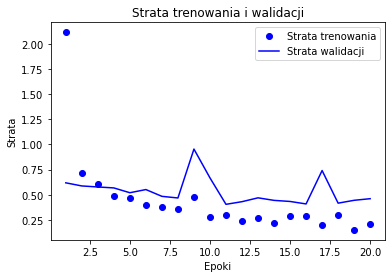

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')

plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

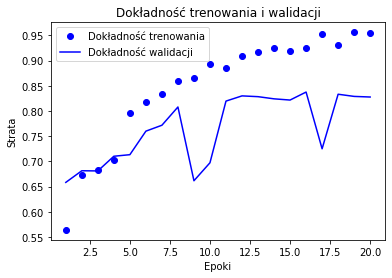

In [11]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacji')

plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

In [12]:
test_data = pd.read_csv('../Data/test.csv')

nan_idx = test_data[pd.isnull(test_data.text)].index.tolist()
test_data.loc[nan_idx, 'text'] = ' '

sequences = tokenizer.texts_to_sequences(test_data.text)

x_test = pad_sequences(sequences, maxlen=MAX_FEATURE_LEN)
y_test = test_data.label

model.evaluate(x_test, y_test)

5200/5200 [==============================] - 1s 209us/step


[0.9495357094361232, 0.7307692170143127]